In [194]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import sys
#sys.path.append('/beegfs/desy/user/akorol/projects/point-cloud-diffusion/')

/tmp/ipykernel_111238/1737663435.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [195]:
import math
import argparse
import h5py
import importlib
import numpy as np
import torch
import time
import sys
from torch.utils.data import DataLoader
from torch.nn.utils import clip_grad_norm_

from models.vae_flow import *
from models.flow import add_spectral_norm, spectral_norm_power_iteration
from configs import Configs
from utils.plotting import get_projections, get_plots, MAP, offset, layer_bottom_pos, cell_thickness, Xmax, Xmin, Zmax, Zmin
from tqdm import tqdm

import k_diffusion as K


cfg = Configs()

print(cfg.__dict__)

{'name': 'kCaloClouds_', 'Acomment': 'baseline with lat_dim = 0, max_iter 500k, lr=1e-4 fixed, bs=128, diffusion_loss=l2', 'comet_project': 'k-CaloClouds', 'log_comet': True, 'model_name': 'epicVAE_nFlow_kDiffusion', 'latent_dim': 0, 'beta_1': 0.0001, 'beta_T': 0.02, 'sched_mode': 'quardatic', 'flexibility': 0.0, 'truncate_std': 2.0, 'latent_flow_depth': 14, 'latent_flow_hidden_dim': 256, 'num_samples': 4, 'features': 4, 'sample_num_points': 2048, 'kl_weight': 0.001, 'residual': False, 'cond_features': 2, 'norm_cond': True, 'kld_min': 1.0, 'use_epic': False, 'epic_layers': 5, 'hid_d': 128, 'sum_scale': 0.001, 'weight_norm': True, 'flow_model': 'PiecewiseRationalQuadraticCouplingTransform', 'flow_transforms': 10, 'flow_layers': 2, 'flow_hidden_dims': 128, 'tails': 'linear', 'tail_bound': 10, 'dataset': 'x36_grid', 'dataset_path': '/beegfs/desy/user/akorol/data/calo-clouds/hdf5/high_granular_grid/train/10-90GeV_x36_grid_regular_524k_float32.hdf5', 'quantized_pos': False, 'workers': 32, '

In [32]:
cfg.max_energy = 100
cfg.max_points = 6000

# Flow Model

In [196]:
from pyro.nn import ConditionalDenseNN, DenseNN, ConditionalAutoRegressiveNN
import pyro.distributions as dist
import pyro.distributions.transforms as T
from custom_pyro import ConditionalAffineCouplingTanH


def compile_HybridTanH_model(num_blocks, num_inputs, num_cond_inputs, device):
    # the latent space distribution: choosing a 2-dim Gaussian
    base_dist = dist.Normal(torch.zeros(num_inputs).to(device), torch.ones(num_inputs).to(device))

    input_dim = num_inputs
    count_bins = 8
    transforms = []
    transforms2 = []
      
    input_dim = num_inputs
    split_dim = num_inputs//2
    param_dims1 = [input_dim-split_dim, input_dim-split_dim]
    param_dims2 = [input_dim * count_bins, input_dim * count_bins, input_dim * (count_bins - 1), input_dim * count_bins]

    torch.manual_seed(42)

    for i in range(num_blocks):
        

                    
        hypernet = ConditionalDenseNN(split_dim, num_cond_inputs, [input_dim*10, input_dim*10], param_dims1)
        #hypernet.apply(init_weights)
        ctf = ConditionalAffineCouplingTanH(split_dim, hypernet)
        transforms2.append(ctf)
        transforms.append(ctf)
        
        perm = torch.randperm(input_dim, dtype=torch.long).to(device)
        ff = T.Permute(perm)
        transforms.append(ff)

        
        hypernet = ConditionalDenseNN(split_dim, num_cond_inputs, [input_dim*10, input_dim*10], param_dims1)
        #hypernet.apply(init_weights)
        ctf = ConditionalAffineCouplingTanH(split_dim, hypernet)
        transforms2.append(ctf)
        transforms.append(ctf)

        perm = torch.randperm(input_dim, dtype=torch.long).to(device)
        ff = T.Permute(perm)
        transforms.append(ff)

        
        hypernet = ConditionalDenseNN(split_dim, num_cond_inputs, [input_dim*10, input_dim*10], param_dims1)
        #hypernet.apply(init_weights)
        ctf = ConditionalAffineCouplingTanH(split_dim, hypernet)
        transforms2.append(ctf)
        transforms.append(ctf)
        
        perm = torch.randperm(input_dim, dtype=torch.long).to(device)
        ff = T.Permute(perm)
        transforms.append(ff)
        
        
        
        
        perm = torch.randperm(input_dim, dtype=torch.long).to(device)
        ff = T.Permute(perm)
        transforms.append(ff)
        
        hypernet = DenseNN(num_cond_inputs, [input_dim*4, input_dim*4], param_dims2)
        #hypernet.apply(init_weights)
        ctf = T.ConditionalSpline(hypernet, input_dim, count_bins)
        transforms2.append(ctf)
        transforms.append(ctf)
        

        

        hypernet = ConditionalDenseNN(split_dim, num_cond_inputs, [input_dim*10, input_dim*10], param_dims1)
        #hypernet.apply(init_weights)
        ctf = ConditionalAffineCouplingTanH(split_dim, hypernet)
        transforms2.append(ctf)
        transforms.append(ctf)
        
        perm = torch.randperm(input_dim, dtype=torch.long).to(device)
        ff = T.Permute(perm)
        transforms.append(ff)

        
        hypernet = ConditionalDenseNN(split_dim, num_cond_inputs, [input_dim*10, input_dim*10], param_dims1)
        #hypernet.apply(init_weights)
        ctf = ConditionalAffineCouplingTanH(split_dim, hypernet)
        transforms2.append(ctf)
        transforms.append(ctf)

        perm = torch.randperm(input_dim, dtype=torch.long).to(device)
        ff = T.Permute(perm)
        transforms.append(ff)

        
        hypernet = ConditionalDenseNN(split_dim, num_cond_inputs, [input_dim*10, input_dim*10], param_dims1)
        #hypernet.apply(init_weights)
        ctf = ConditionalAffineCouplingTanH(split_dim, hypernet)
        transforms2.append(ctf)
        transforms.append(ctf)
        
        perm = torch.randperm(input_dim, dtype=torch.long).to(device)
        ff = T.Permute(perm)
        transforms.append(ff)
        
        
        
        
        
    modules = nn.ModuleList(transforms2)

    flow_dist = dist.ConditionalTransformedDistribution(base_dist, transforms)

    return modules, flow_dist

num_blocks = 10
flow, distribution = compile_HybridTanH_model(num_blocks, 
                                           num_inputs=32, ### when 'condioning' on additional Esum, Nhits etc add them on as inputs rather than 
                                           num_cond_inputs=1, device=cfg.device)  # num_cond_inputs

checkpoint = torch.load('/beegfs/desy/user/akorol/chekpoints/ECFlow/EFlow+CFlow_138.pth')
flow.load_state_dict(checkpoint['model'])
flow.eval().to(cfg.device)

print('flow model loaded')

flow model loaded


# Diffusion Model

In [197]:
# from models.allCond_epicVAE_nflow_PointDiff import AllCond_epicVAE_nFlow_PointDiff
# from models.epicVAE_nflows_kDiffusion import epicVAE_nFlow_kDiffusion

import models.epicVAE_nflows_kDiffusion as mdls
import models.allCond_epicVAE_nflow_PointDiff as mdls2
importlib.reload(mdls)
importlib.reload(mdls2)


# cfg.sched_mode = 'quardatic'
# cfg.num_steps = 100
# cfg.residual = True
# cfg.latent_dim = 256
# model = mdls2.AllCond_epicVAE_nFlow_PointDiff(cfg).to(cfg.device)
# checkpoint = torch.load('/beegfs/desy/user/akorol/logs/point-cloud/AllCond_epicVAE_nFlow_PointDiff_100s_MSE_loss_smired_possitions_quardatic2023_04_06__16_34_39/ckpt_0.000000_837000.pt') # quadratic
# model.load_state_dict(checkpoint['state_dict'])




# cfg.model['sigma_data'] = 0.5
# cfg.residual = False
# cfg.dropout_rate = 0.0
# cfg.latent_dim = 256
# checkpoint = torch.load(cfg.logdir + '/' + 'kCaloClouds_2023_05_24__14_54_09/ckpt_0.000000_500000.pt')    # EDM BASELINE first training
# checkpoint = torch.load(cfg.logdir + '/' + 'kCaloClouds_2023_05_31__17_57_11/ckpt_0.000000_1700000.pt')

# cfg.model['sigma_data'] = 0.08
# checkpoint = torch.load(cfg.logdir + '/' + 'kCaloClouds_2023_06_01__13_28_09/ckpt_0.000000_340000.pt')  # too wide cog_Y, too low hit_E

# RAdam optimizer - sigma_data=0.5, residual=False, lr=2e-3, dropout_rate=0.1
# cfg.model['sigma_data'] = 0.5
# cfg.residual = False
# cfg.model['dropout_rate'] = 0.1
# checkpoint = torch.load(cfg.logdir + '/' + 'kCaloClouds_2023_06_02__16_43_14/ckpt_0.000000_258000.pt')

# # RAdam optimizer, 2M iterations, scheduler from 300k-2M, EMApower 0.6667 - sigma_data=0.25
# cfg.model['sigma_data'] = 0.25
# cfg.residual = False
# cfg.model['dropout_rate'] = 0.0
# checkpoint = torch.load(cfg.logdir + '/' + 'kCaloClouds_2023_06_02__15_55_11/ckpt_0.000000_1000000.pt')

# # RAdam optimizer - sigma_data=0.5, residual=False, lr=1e-4, dropout_rate=0.0
# cfg.model['sigma_data'] = 0.5
# cfg.residual = False
# cfg.model['dropout_rate'] = 0.0
# checkpoint = torch.load(cfg.logdir + '/' + 'kCaloClouds_2023_06_02__16_40_41/ckpt_0.000000_1000000.pt')

# # RAdam optimizer - sigma_data=0.5, residual=True, lr=2e-3, dropout_rate=0.0
# cfg.model['sigma_data'] = 0.5
# cfg.residual = True
# cfg.model['dropout_rate'] = 0.0
# checkpoint = torch.load(cfg.logdir + '/' + 'kCaloClouds_2023_06_02__16_36_04/ckpt_0.000000_920000.pt')

# # RAdam optimizer - sigma_data=0.5, residual=False, lr=2e-3, dropout_rate=0.1
# cfg.model['sigma_data'] = 0.5
# cfg.residual = False
# cfg.model['dropout_rate'] = 0.1
# checkpoint = torch.load(cfg.logdir + '/' + 'kCaloClouds_2023_06_03__10_24_31/ckpt_0.000000_737000.pt')

# # "sigma_data" : [0.08, 0.35, 0.08, 0.5]
# cfg.model['sigma_data'] = [0.08, 0.35, 0.08, 0.5]
# checkpoint = torch.load(cfg.logdir + '/' + 'kCaloClouds_2023_06_05__17_27_15/ckpt_0.000000_300000.pt')

# # "sigma_data = 1
# cfg.model['sigma_data'] = 1.
# checkpoint = torch.load(cfg.logdir + '/' + 'kCaloClouds_2023_06_05__17_28_38/ckpt_0.000000_280000.pt')

# # ""sigma_data = 0.1
# cfg.model['sigma_data'] = 0.1
# cfg.dropout_rate = 0.0
# checkpoint = torch.load(cfg.logdir + '/' + 'kCaloClouds_2023_06_06__13_34_50/ckpt_0.000000_375000.pt')

# # "sigma_data = 0.5, dropout=0.05
# cfg.model['sigma_data'] = 0.5
# cfg.dropout_rate = 0.05
# checkpoint = torch.load(cfg.logdir + '/' + 'kCaloClouds_2023_06_06__14_21_41/ckpt_0.000000_320000.pt')

# # "sigma_data = 0.5, dropout=0.025
# cfg.model['sigma_data'] = 0.5
# cfg.dropout_rate = 0.025
# cfg.latent_dim = 256
# checkpoint = torch.load(cfg.logdir + '/' + 'kCaloClouds_2023_06_07__14_36_04/ckpt_0.000000_410000.pt')

# # "sigma_data = 0.5, dropout=0.01
# cfg.model['sigma_data'] = 0.5
# cfg.dropout_rate = 0.01
# cfg.latent_dim = 256
# checkpoint = torch.load(cfg.logdir + '/' + 'kCaloClouds_2023_06_07__14_35_01/ckpt_0.000000_375000.pt')

# # "sigma_data = 0.5, dropout=0.0, latent=32
# cfg.model['sigma_data'] = 0.5
# cfg.dropout_rate = 0.0
# cfg.latent_dim = 32
# checkpoint = torch.load(cfg.logdir + '/' + 'kCaloClouds_2023_06_07__17_36_22/ckpt_0.000000_410000.pt')

# # "sigma_data = 0.5, dropout=0.0, latent=8
# cfg.model['sigma_data'] = 0.5
# cfg.dropout_rate = 0.0
# cfg.latent_dim = 8
# checkpoint = torch.load(cfg.logdir + '/' + 'kCaloClouds_2023_06_09__14_59_24/ckpt_0.000000_500000.pt')

# # "sigma_data = 0.5, dropout=0.0, latent=2
# cfg.model['sigma_data'] = 0.5
# cfg.dropout_rate = 0.0
# cfg.latent_dim = 2
# checkpoint = torch.load(cfg.logdir + '/' + 'kCaloClouds_2023_06_09__19_23_03/ckpt_0.000000_500000.pt')

# baseline with latent_dim = 32, max_iter 500k, kld_weight=1e-5
# cfg.model['sigma_data'] = 0.5
# cfg.dropout_rate = 0.0
# cfg.latent_dim = 32
# checkpoint = torch.load(cfg.logdir + '/' + 'kCaloClouds_2023_06_15__14_54_11/ckpt_0.000000_410000.pt')

# # baseline with latent_dim = 32, max_iter 500k, kld_weight=1e-6
# cfg.model['sigma_data'] = 0.5
# cfg.dropout_rate = 0.0
# cfg.latent_dim = 32
# checkpoint = torch.load(cfg.logdir + '/' + 'kCaloClouds_2023_06_15__16_12_53/ckpt_0.000000_410000.pt')

# # baseline with lat_dim = 256, max_iter 500k, lr=1e-4 fixed, bs=128, diffusion_loss=l1
# cfg.dropout_rate = 0.0
# cfg.latent_dim = 256
# checkpoint = torch.load(cfg.logdir + '/' + 'kCaloClouds_2023_06_26__14_42_09/ckpt_0.000000_500000.pt')    # EDM BASELINE first training

# baseline with lat_dim = 256, max_iter 500k, lr=1e-4 fixed, bs=128, diffusion_loss=l1
cfg.dropout_rate = 0.0
cfg.latent_dim = 0
checkpoint = torch.load(cfg.logdir + '/' + 'kCaloClouds_2023_06_26__18_55_23/ckpt_0.000000_500000.pt')    # EDM BASELINE first training


model = mdls.epicVAE_nFlow_kDiffusion(cfg).to(cfg.device)
model.load_state_dict(checkpoint['others']['model_ema'])
# model.load_state_dict(checkpoint['state_dict'])

#  load model with torch load with name "model_ema


# checkpoint = torch.load('/beegfs/desy/user/akorol/logs/point-cloud/AllCond_epicVAE_nFlow_PointDiff_100s2023_03_29__14_39_04/ckpt_0.000000_570000.pt') #worst cog x
# checkpoint = torch.load('/beegfs/desy/user/akorol/logs/point-cloud/AllCond_epicVAE_nFlow_PointDiff_100s2023_03_29__14_39_04/ckpt_0.000000_748000.pt') #best cog x

# checkpoint = torch.load('/beegfs/desy/user/akorol/logs/point-cloud/AllCond_epicVAE_nFlow_PointDiff_100s_MSE_loss_smired_possitions_sigmoid2023_04_06__16_35_47/ckpt_0.000000_849000.pt') # sigmoid 
# checkpoint = torch.load('/beegfs/desy/user/akorol/logs/point-cloud/AllCond_epicVAE_nFlow_PointDiff_100s_MSE_loss_smired_possitions_quardatic2023_04_06__16_34_39/ckpt_0.000000_837000.pt') # quadratic



# CONSISTENCY MODESL

# cfg.model['sigma_data'] = 0.5
# cfg.residual = False
# cfg.dropout_rate = 0.0
# cfg.latent_dim = 256
# CD baseline with lat_dim = 256, max_iter 1M, lr=1e-3 fixed, num_steps=18, bs=256
# checkpoint = torch.load(cfg.logdir + '/' + 'CD_2023_06_23__13_28_07/ckpt_0.000000_650000.pt') 
# CD baseline with lat_dim = 256, max_iter 1M, lr=1e-4 fixed, num_steps=18, bs=256
# checkpoint = torch.load(cfg.logdir + '/' + 'CD_2023_06_23__13_30_39/ckpt_0.000000_700000.pt')
# CD baseline with lat_dim = 256, max_iter 1M, lr=1e-4 fixed, num_steps=40, bs=256
# checkpoint = torch.load(cfg.logdir + '/' + 'CD_2023_06_23__13_31_45/ckpt_0.000000_695000.pt')

# model = mdls.epicVAE_nFlow_kDiffusion(cfg, distillation = True).to(cfg.device)
# model.load_state_dict(checkpoint['others']['model_ema'])




model.eval()

print('model loaded')

model loaded


In [198]:
def get_scale_factor(num_clusters):
    
    # CaloClouds
    # coef_real = np.array([ 2.57988645e-09, -2.94056522e-05,  3.42194568e-01,  5.34968378e+01])
    # coef_fake = np.array([ 3.85057207e-09, -4.16463897e-05,  4.19800713e-01,  5.82246858e+01])

    # kCaloClouds_2023_05_24__14_54_09_heun18
    # coef_real = np.array([ 2.39735048e-09, -2.69842295e-05,  2.96136986e-01,  4.89770787e+01])
    # coef_fake = np.array([ 4.45753201e-09, -4.26483492e-05,  4.03632976e-01,  6.31063427e+01])

    # kCaloClouds_2023_05_24__14_54_09_heun13
    coef_real = np.array([ 2.39735048e-09, -2.69842295e-05,  2.96136986e-01,  4.89770787e+01])
    coef_fake = np.array([ 5.72940149e-09, -4.76120436e-05,  4.37720799e-01,  5.97962496e+01])
    
    poly_fn_real = np.poly1d(coef_real)
    poly_fn_fake = np.poly1d(coef_fake) 
    
    scale_factor = poly_fn_real(num_clusters) / poly_fn_fake(num_clusters)

    return scale_factor

def get_shower(num_points, energy, cond_N, bs=1, kdiffusion=False, config=None):
#     e = torch.ones((bs, 1), device=cfg.device) * float(energy)
#     n = torch.ones((bs, 1), device=cfg.device) * float(num_points)

    e = torch.ones((bs, 1), device=cfg.device) * energy
    n = torch.ones((bs, 1), device=cfg.device) * cond_N
    
    if cfg.norm_cond:
        e = e / 100 * 2 -1   # max incident energy: 100 GeV
        n = n / cfg.max_points * 2  - 1
    cond_feats = torch.cat([e, n], -1)
        
    with torch.no_grad():
        if kdiffusion:
            fake_shower = model.sample(cond_feats, num_points, config)
        else:
            fake_shower = model.sample(cond_feats, num_points, cfg.flexibility)
    
    return fake_shower



# batch inference 
def gen_showers_batch(e_min, e_max, num=2000, bs=32, kdiffusion=False, config=None):
    
    cond_E = torch.FloatTensor(num, 1).uniform_(e_min, e_max).to(cfg.device)
    samples = distribution.condition(cond_E/100).sample(torch.Size([num, ])).cpu().numpy()
    
    energies = (samples[:, 0] * 2.5 * 1000).reshape(num, 1)
    
    clusters_per_layer_gen = samples[:, 2:] * 400
    clusters_per_layer_gen[clusters_per_layer_gen < 0] = 0

    scale_factor = get_scale_factor(clusters_per_layer_gen.sum(axis=1))
    scale_factor = np.expand_dims(scale_factor, axis=1)

    clusters_per_layer_gen = (clusters_per_layer_gen * scale_factor).astype(int)
    # clusters_per_layer_gen = (clusters_per_layer_gen).astype(int)

    # sort by number of clusters for better batching and faster inference
    mask = np.argsort(clusters_per_layer_gen.sum(axis=1))
    clusters_per_layer_gen = clusters_per_layer_gen[mask]
    energies = energies[mask]
    cond_E = cond_E[mask]

    fake_showers_list = []
    
    
    for evt_id in tqdm(range(0, num, bs)):
        if (num - evt_id) < bs:
            bs = num - evt_id
#         num = num - 75 # substruct correction factor
        # convert clusters_per_layer_gen to a fractions of points in the layer out of sum(points in the layer) of event
        # multuply clusters_per_layer_gen by corrected tottal num of points
        hits_per_layer_all = clusters_per_layer_gen[evt_id : evt_id+bs] # shape (bs, num_layers) 
        max_num_clusters = hits_per_layer_all.sum(axis=1).max()
        cond_N = torch.Tensor(hits_per_layer_all.sum(axis=1)).to(cfg.device).unsqueeze(-1)
        
        fs = get_shower(max_num_clusters, cond_E[evt_id : evt_id+bs], cond_N, bs=bs, kdiffusion=kdiffusion, config=config)
        fs = fs.cpu().numpy()
        
#         if np.isnan(fs).sum() != 0:
# #             return fs
#             print('nans in showers!')
#             fs[np.isnan(fs)] = 0
# #             break
        
        
        for i, hits_per_layer in enumerate(hits_per_layer_all):
    
            n_hits_to_concat = max_num_clusters - hits_per_layer.sum()

            y_flow = np.repeat(layer_bottom_pos+cell_thickness/2, hits_per_layer)
            y_flow = np.concatenate([y_flow, np.zeros(n_hits_to_concat)])

            mask = np.concatenate([ np.ones( hits_per_layer.sum() ), np.zeros( n_hits_to_concat ) ])

            fs[i, :, 1][mask == 0] = 10
            idx_dm = np.argsort(fs[i, :, 1])
            fs[i, :, 1][idx_dm] = y_flow


            fs[i, :, :][y_flow==0] = 0        

        
        fs[:, :, -1][fs[:, :, -1]  < 0] = 0    # setting negative energies to 0
        fs[:, :, -1] = fs[:, :, -1] / fs[:, :, -1].sum(axis=1).reshape(bs, 1) * energies[evt_id : evt_id+bs] # energy rescaling to predicted e_sum

        length = 6000 - fs.shape[1]
        fs = np.concatenate((fs, np.zeros((bs, length, 4))), axis=1)
        fake_showers_list.append(fs)
        
    fake_showers = np.vstack(fake_showers_list)
    
    fake_showers = np.moveaxis(fake_showers, -1, -2)
    fake_showers[:, 0, :] = (fake_showers[:, 0, :] + 1) / 2
    fake_showers[:, 2, :] = (fake_showers[:, 2, :] + 1) / 2
    
    fake_showers[:, 0] = fake_showers[:, 0] * (Xmin-Xmax) + Xmax
    fake_showers[:, 2] = fake_showers[:, 2] * (Zmin-Zmax) + Zmax
    
    return fake_showers

In [199]:
kdiffusion=True
cfg.num_steps = 13
cfg.sampler = 'heun'
cfg.s_churn =  0.0     # stochasticity, default 0.0  (if s_churn more than num_steps, it will be clamped to max value)
cfg.s_noise = 1.0    # default 1.0   # noise added when s_churn > 0
cfg.sigma_max = 80.0 #  5.3152e+00  # default 80.0
cfg.sigma_min = 0.002   # default 0.002
cfg.rho = 7. # default 7.0

s_t = time.time()
fake_showers_3 = gen_showers_batch(50, 50, 2000, bs=64, kdiffusion=kdiffusion, config=cfg)
t = time.time() - s_t
print(fake_showers_3.shape)
print(t)
print('time per shower: ', t / 2000)

100%|██████████| 32/32 [00:08<00:00,  3.83it/s]


(2000, 4, 6000)
8.61511778831482
time per shower:  0.00430755889415741


In [200]:
sigmas = K.sampling.get_sigmas_karras(cfg.num_steps, cfg.sigma_min, cfg.sigma_max, rho=cfg.rho)
print(sigmas)


tensor([8.0000e+01, 4.9979e+01, 3.0183e+01, 1.7528e+01, 9.7232e+00, 5.1092e+00,
        2.5152e+00, 1.1431e+00, 4.6998e-01, 1.6975e-01, 5.1532e-02, 1.2238e-02,
        2.0000e-03, 0.0000e+00])


In [201]:
# %%timeit
# with torch.no_grad():
#     fake_showers = get_shower(4000, 50, 50)

In [202]:
#np.save('/beegfs/desy/user/buhmae/6_PointCloudDiffusion/output/CCbaseline_50GeV_2000.npy', fake_showers)
# np.save('/beegfs/desy/user/buhmae/6_PointCloudDiffusion/output/kCaloClouds_2023_05_24__14_54_09_heun18_10-90GeV_40k.npy', fake_showers_2)
# np.save('/beegfs/desy/user/buhmae/6_PointCloudDiffusion/output/kCaloClouds_2023_05_24__14_54_09_heun18_50GeV_2k.npy', fake_showers_2)
# np.save('/beegfs/desy/user/buhmae/6_PointCloudDiffusion/output/kCaloClouds_2023_05_24__14_54_09_heun13_10-90GeV_40k.npy', fake_showers_3)
# np.save('/beegfs/desy/user/buhmae/6_PointCloudDiffusion/output/kCaloClouds_2023_05_24__14_54_09_heun13_50GeV_2k.npy', fake_showers_3)

# Plots

In [203]:
from utils.plotting import get_projections, get_plots, MAP, offset, layer_bottom_pos, cell_thickness, plt_cog
from utils.plotting import cfg as cfg_plt
import utils.plotting as plotting

import numpy as np
import h5py
import matplotlib.pyplot as plt

In [204]:
path = '/beegfs/desy/user/akorol/data/calo-clouds/hdf5/high_granular_grid/validation/50GeV_x36_grid_regular_2k_Z4.hdf5'
# path = '/beegfs/desy/user/akorol/projects/getting_high/ILDConfig/StandardConfig/production/out/10GeV_x36_grid_regular_2k_Z4_grid_pos_rundom.hdf5'
real_showers = h5py.File(path, 'r')['events'][:]

# fake_showers = np.load('new_DM_50GeV_scaled_2.npy')
# fake_showers[:, -1] = fake_showers[:, -1] / 1000

# fake_showers_2 = np.load('new_DM_50GeV_scaled.npy')
# fake_showers_2[:, -1] = fake_showers_2[:, -1] / 1000

# fake_showers_3 = np.load('new_DM_50GeV_scaled_3.npy')
# fake_showers_3[:, -1] = fake_showers_3[:, -1] / 1000

# fake_showers = np.load('/beegfs/desy/user/akorol/projects/point-cloud/DM_100s_30GeV_rearanged.npy')
# fake_showers[:, -1] = fake_showers[:, -1] / 1000

fake_showers = np.load('/beegfs/desy/user/buhmae/6_PointCloudDiffusion/output/CCbaseline_50GeV_2000.npy')
fake_showers[:, -1] = fake_showers[:, -1] / 1000

# fake_showers_2 = np.load('/beegfs/desy/user/buhmae/6_PointCloudDiffusion/output/kCaloClouds_2023_05_24__14_54_09_heun18_50GeV_2k.npy')
fake_showers_2 = np.load('/beegfs/desy/user/buhmae/6_PointCloudDiffusion/output/kCaloClouds_2023_05_24__14_54_09_heun13_50GeV_2k.npy')
fake_showers_2[:, -1] = fake_showers_2[:, -1] / 1000

# fake_showers_2 = np.load('/beegfs/desy/user/akorol/projects/point-cloud/DM_new_100s_50GeV_with_flow_corrections_best_cog.npy')
#fake_showers_2[:, -1] = fake_showers_2[:, -1] / 1000

# fake_showers_3 = np.load('/beegfs/desy/user/akorol/projects/point-cloud/DM_new_100s_90GeV_with_flow_corrections_3.npy')
fake_showers_3[:, -1] = fake_showers_3[:, -1] / 1000

# fake_showers_2 = np.load('/beegfs/desy/user/akorol/projects/point-cloud/DM_500s_10GeV_rearanged.npy')
# fake_showers_2[:, -1] = fake_showers_2[:, -1] / 1000


# fake_showers_worst = np.load('DM_10GeV_worst.npy')
# fake_showers_worst[:, -1] = fake_showers_worst[:, -1] / 1000

# fake_showers_worst_2 = np.load('DM_10GeV_worst_2.npy')
# fake_showers_worst_2[:, -1] = fake_showers_worst_2[:, -1] / 1000

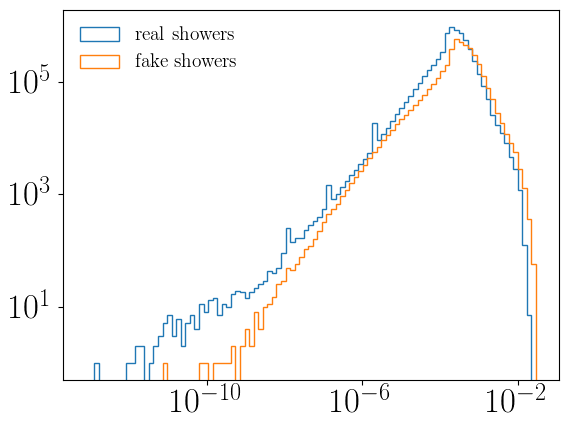

In [205]:
# log bins 
bins = np.logspace(np.log10(real_showers[:,-1,:][real_showers[:,-1,:] != 0.0].min()),np.log10(real_showers[:,-1,:].max()), 100)
plt.hist(real_showers[:,-1,:][real_showers[:,-1,:] != 0.0], bins = bins, histtype='step', label='real showers', density=False)
plt.hist(fake_showers_3[:,-1,:][fake_showers_3[:,-1,:] != 0.0], bins = bins, histtype='step', label='fake showers', density=False)   
plt.legend(loc='best', fontsize=14)
plt.yscale('log')
plt.xscale('log')
plt.show()

In [206]:
fake_showers_3[:,0,:].max()

263.68408203125

In [207]:
def get_cog(x,y,z,e):
    return np.sum((x * e), axis=1) / e.sum(axis=1), np.sum((y * e), axis=1) / e.sum(axis=1), np.sum((z * e), axis=1) / e.sum(axis=1)

In [208]:
fake_showers[:, 0] = fake_showers[:, 0] - (-0.10704701695531388) # calulated as cog_2[0].mean() - cog[0].mean() for 40k samples, E form 10 to 100 GeV
fake_showers[:, 2] = fake_showers[:, 2] - (-0.3062229876492353) # calulated as cog_2[2].mean() - cog[2].mean() for 40k samples, E from 10 to 100 GeV

In [209]:
cog = get_cog(
    real_showers[:, 0],
    real_showers[:, 1],
    real_showers[:, 2],
    real_showers[:, 3],
)

cog_2 = get_cog(
    fake_showers[:, 0],
    fake_showers[:, 1],
    fake_showers[:, 2],
    fake_showers[:, 3],
)

cog_3 = get_cog(
    fake_showers_2[:, 0],
    fake_showers_2[:, 1],
    fake_showers_2[:, 2],
    fake_showers_2[:, 3],
)

cog_4 = get_cog(
    fake_showers_3[:, 0],
    fake_showers_3[:, 1],
    fake_showers_3[:, 2],
    fake_showers_3[:, 3],
)

100%|██████████| 30/30 [00:00<00:00, 280.35it/s]


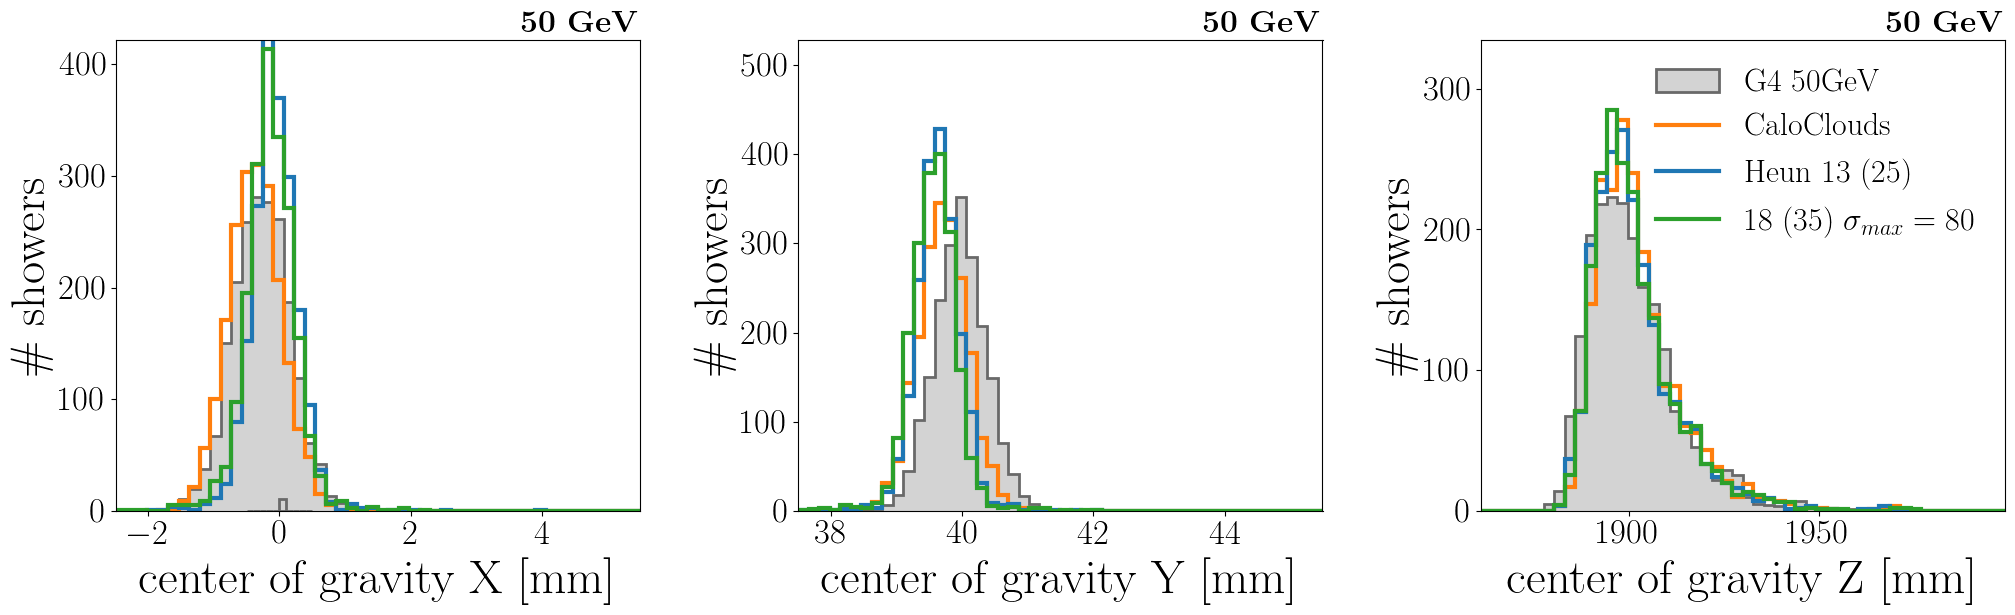

In [210]:
importlib.reload(plotting)

plotting.plt_cog(cog, [cog_2, cog_3, cog_4], ['G4 50GeV', 'CaloClouds', 'Heun 13 (25)', r'18 (35) $\sigma_{max}=80$'], title=r'\textbf{50 GeV}')

100%|██████████| 30/30 [00:00<00:00, 282.20it/s]


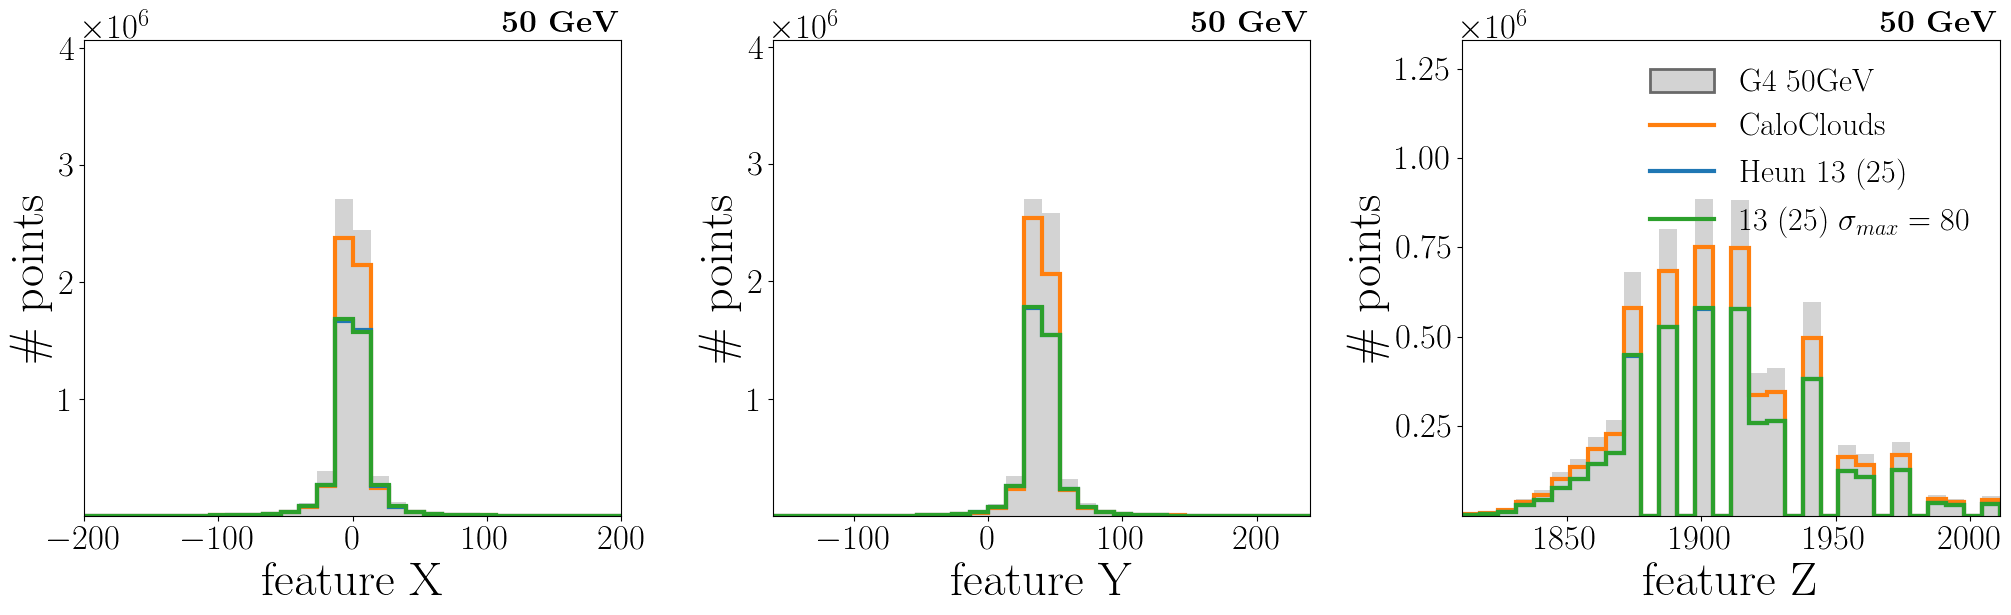

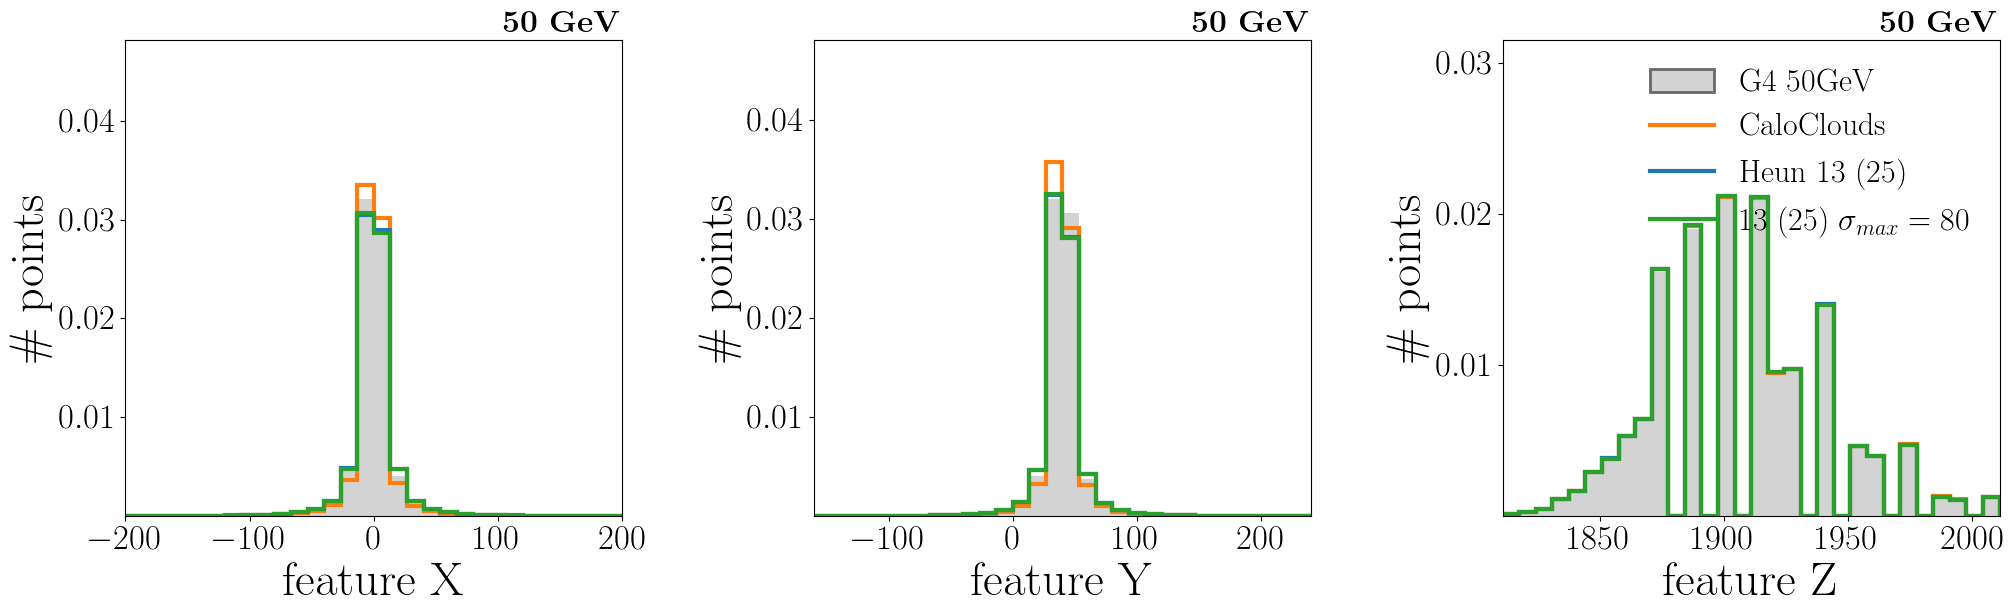

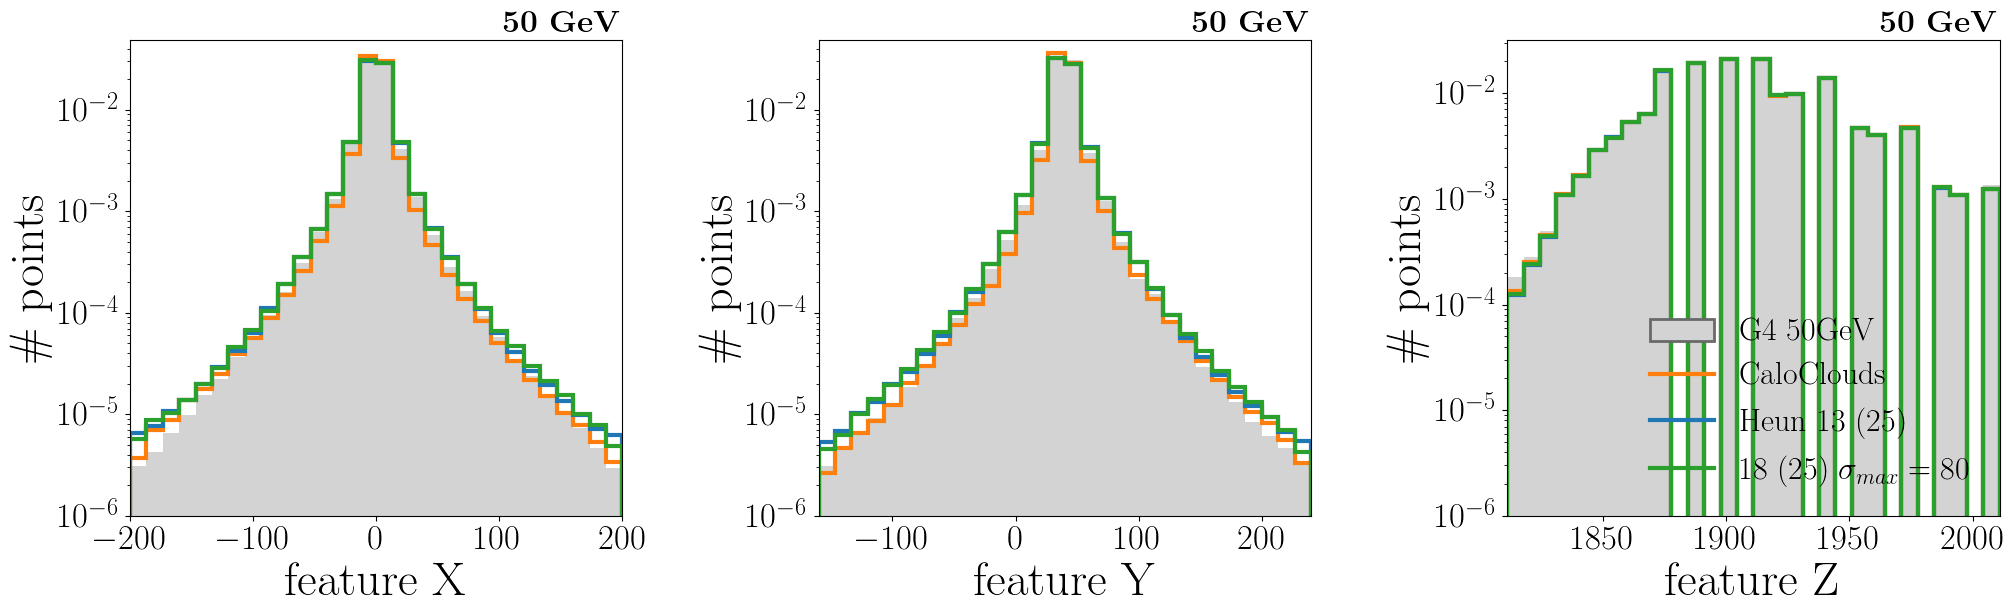

In [211]:
importlib.reload(plotting)

plotting.plt_feats(real_showers, [fake_showers, fake_showers_2, fake_showers_3], ['G4 50GeV', 'CaloClouds', 'Heun 13 (25)', r'13 (25) $\sigma_{max}=80$'], title=r'\textbf{50 GeV}', density=False)
plotting.plt_feats(real_showers, [fake_showers, fake_showers_2, fake_showers_3], ['G4 50GeV', 'CaloClouds', 'Heun 13 (25)', r'13 (25) $\sigma_{max}=80$'], title=r'\textbf{50 GeV}', density=True)
plotting.plt_feats(real_showers, [fake_showers, fake_showers_2, fake_showers_3], ['G4 50GeV', 'CaloClouds', 'Heun 13 (25)', r'18 (25) $\sigma_{max}=80$'], title=r'\textbf{50 GeV}', scale='log', density=True)

In [212]:
cfg.bins_r = 35

In [213]:
(fake_showers[:,3,:] > 0.0).sum() / 2000

2665.7865

In [214]:
(fake_showers_3[:,3,:] > 0.0).sum() / 2000

2055.2025

In [215]:
(real_showers[:,3,:] > 0.0).sum() / 2000

3164.053

In [216]:
# events = get_projections(real_showers, MAP, layer_bottom_pos)
# events_fake = get_projections(fake_showers, MAP, layer_bottom_pos)
# events_fake_2 = get_projections(fake_showers_2, MAP, layer_bottom_pos)
events_fake_3 = get_projections(fake_showers_3, MAP, layer_bottom_pos)

100%|██████████| 2000/2000 [00:06<00:00, 295.15it/s]


100%|██████████| 2000/2000 [00:04<00:00, 411.80it/s]


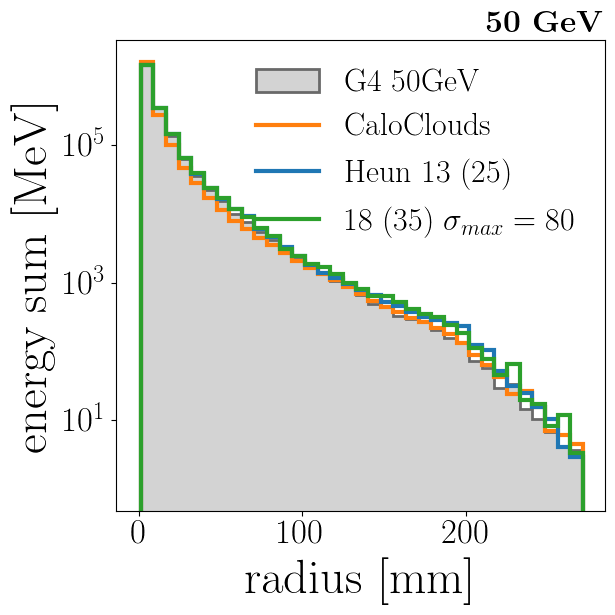

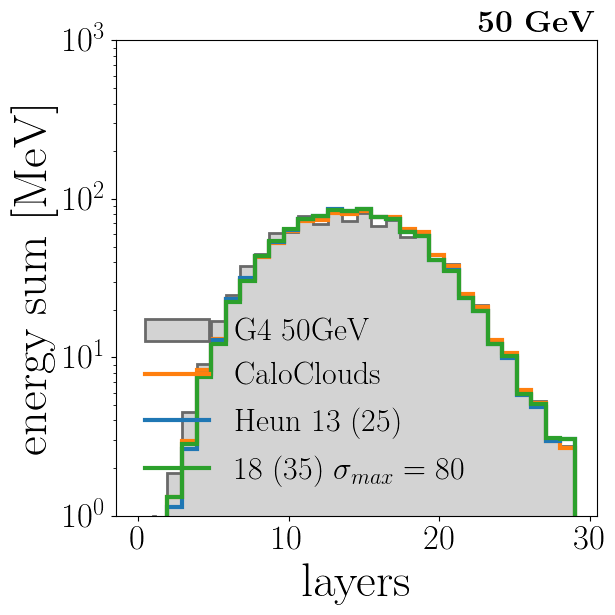

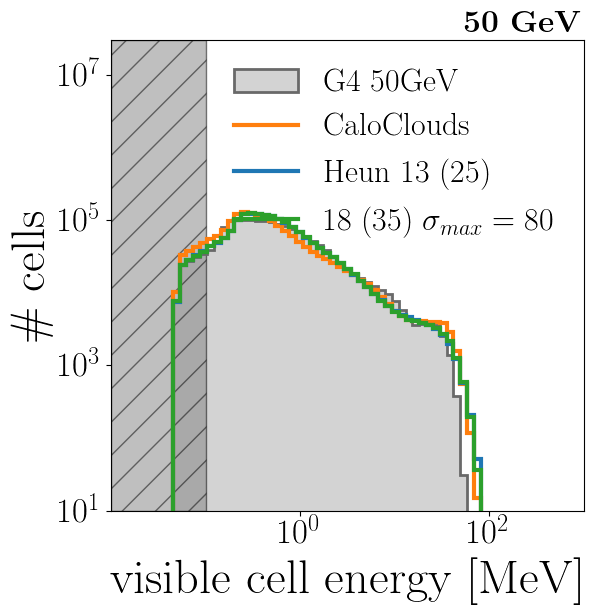

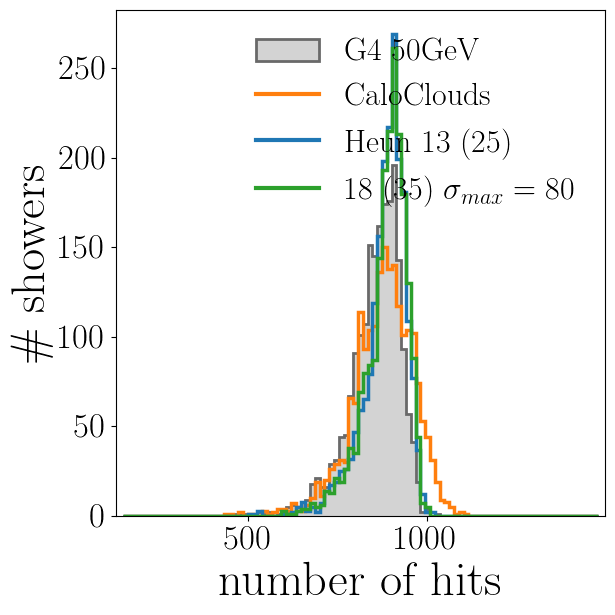

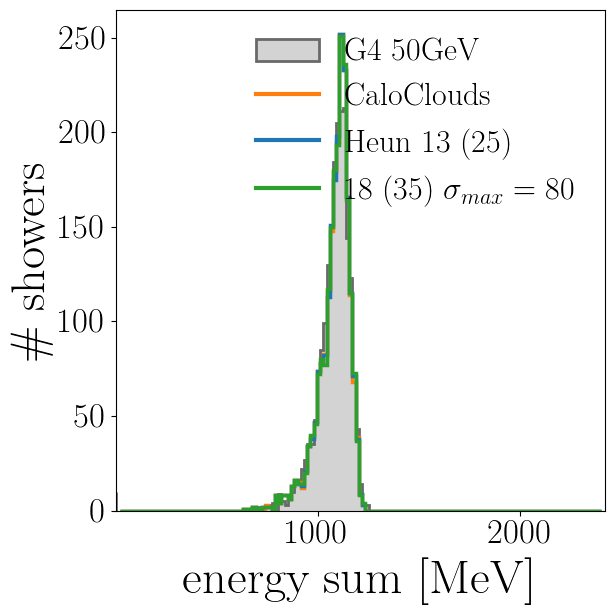

In [217]:
# get_plots(events, [events_fake, events_fake_2],
importlib.reload(plotting)
plotting.get_plots(events, [events_fake, events_fake_2, events_fake_3],
            labels = ['G4 50GeV', 'CaloClouds', 'Heun 13 (25)', r'18 (35) $\sigma_{max}=80$'],
            title=r'\textbf{50 GeV}',
         )